In [689]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def prettify():
    plt.xticks(rotation=70)
    plt.show()

In [690]:


df = pd.read_csv('../src/data/california.csv')
df.Date = pd.to_datetime(df.Date)

# experiments
# df.Delta = np.exp(df.Delta)
# df.TotalVolume = np.log(df.TotalVolume)

avocado, avocado_test = pd.Series(df.TotalVolume)[0:400], pd.Series(df.TotalVolume)[400:]
prices, prices_test = pd.Series(df.Delta)[0:400], pd.Series(df.Delta)[400:]

avocado.index = df.Date.iloc[0:400]
prices.index = df.Date.iloc[0:400]


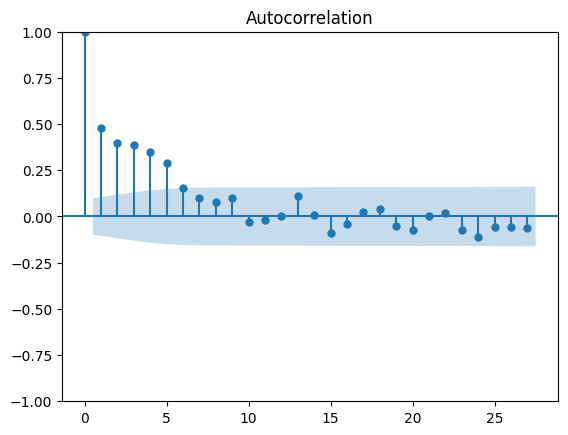

In [691]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(avocado)
plt.show()

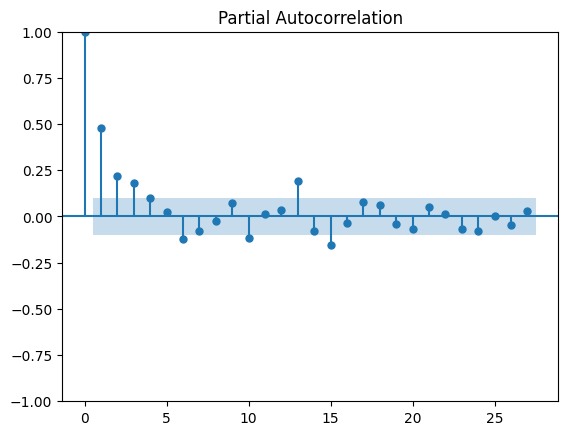

In [692]:
plot_pacf(avocado)
plt.show()

In [693]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.base import ForecastingHorizon


fh = ForecastingHorizon(1)

cv = SlidingWindowSplitter(start_with_window=True, fh=fh, step_length=10, window_length=110)
forecaster = ARIMA(enforce_invertibility=False, enforce_stationarity=False, suppress_warnings=True)
arima_orders = []
start_p, start_q, start_d = 1, 1, 0
max_p = 5
max_q = 5
max_d = 1
for p in range(start_p, max_p+1):
    for q in range(start_q, max_q+1):
        for d in range(start_d, max_d + 1):
            # if set([p, q]) != set([6, 7]):
                arima_orders.append((p, d, q))
param_grid = {"order": arima_orders, 
            }

In [694]:
grid_searcher = ForecastingGridSearchCV(
    forecaster=forecaster,
    cv=cv,
    param_grid=param_grid,
    error_score='raise',
    backend="multiprocessing"
)
# avocado.fillna(0, inplace=True)
grid_searcher.fit(avocado, X=prices.fillna(0))

/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is ava

ForecastingGridSearchCV(backend='multiprocessing',
                        cv=SlidingWindowSplitter(fh=ForecastingHorizon([1], dtype='int64', is_relative=True),
                                                 step_length=10,
                                                 window_length=110),
                        error_score='raise',
                        forecaster=ARIMA(enforce_invertibility=False,
                                         enforce_stationarity=False,
                                         suppress_warnings=True),
                        param_grid={'order': [(1, 0, 1), (1, 1, 1), (1, 0, 2),
                                              (1, 1, 2), (1, 0, 3), (1, 1, 3),
                                              (1, 0, 4), (1, 1, 4), (1, 0, 5),
                                              (1, 1, 5), (2, 0, 1), (2, 1, 1),
                                              (2, 0, 2), (2, 1, 2), (2, 0, 3),
                                              (2, 1, 3), (2, 0, 4), (2, 1, 4),
                                              (2, 0, 5), (2, 1, 5), (3, 0, 1),
                                              (3, 1, 1), (3, 0, 2), (3, 1, 2),
                                              (3, 0, 3), (3, 1, 3), (3, 0, 4),
                                              (3, 1, 4), (3, 0, 5), (3, 1, 5), ...]})

In [695]:
grid_searcher.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:               SARIMAX(3, 1, 4)   Log Likelihood               -5864.887
Date:                Tue, 01 Apr 2025   AIC                          11749.774
Time:                        16:51:53   BIC                          11789.538
Sample:                             0   HQIC                         11765.531
                                - 400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    326.7905   1.55e-06    2.1e+08      0.000     326.790     326.790
Delta      -4.436e+06   1.97e-07  -2.25e+13      0.000   -4.44e+06   -4.44e+06
ar.L1          0.5446      0.067      8.144      0.000       0.414       0.676
ar.L2         -0.8970      0.113     -7.924      0.000      -1.119      -0.675
ar.L3          0.4010      0.094      4.256      0.000       0.216       0.586
ma.L1         -1.7846      0.141    -12.691      0.000      -2.060      -1.509
ma.L2          1.2769      0.287      4.448      0.000       0.714       1.839
ma.L3         -1.0808      0.276     -3.921      0.000      -1.621      -0.541
ma.L4          0.0873      0.160      0.546      0.585      -0.226       0.401
sigma2       4.02e+11    1.4e-12   2.88e+23      0.000    4.02e+11    4.02e+11
===================================================================================
Ljung-Box (L1) (Q):                  29.56   Jarque-Bera (JB):               189.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.24e+40. Standard errors may be unstable.
"""

In [696]:
grid_searcher.best_forecaster_.get_fitted_params()

{'intercept': 326.7904933357353,
 'Delta': -4435953.51260991,
 'ar.L1': 0.5446229031076572,
 'ar.L2': -0.8969741385019426,
 'ar.L3': 0.4009691685392639,
 'ma.L1': -1.7845879874399881,
 'ma.L2': 1.2768510630785546,
 'ma.L3': -1.0807840628840446,
 'ma.L4': 0.08731273085947337,
 'sigma2': 402026904622.2513,
 'aic': 11749.774480189884,
 'aicc': 11750.34889272252,
 'bic': 11789.537989282864,
 'hqic': 11765.530683507257}

In [697]:
grid_searcher.best_score_

0.06287444206575946

In [698]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

results = evaluate(
    forecaster=grid_searcher.best_forecaster_,
    y=avocado,
    X=prices,
    cv=cv,
    scoring=mean_absolute_percentage_error,
    return_data=True,
).dropna()






/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ARIMA failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=110.
                The score will be set to nan.
                Failed forecaster with parameters: ARIMA(enforce_invertibility=False, enforce_stationarity=False, order=(3, 1, 4),
      suppress_warnings=True).
                
  ret = [fun(x, meta=meta) for x in iter]
/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/grigorychaykovsky/retail_f

In [699]:
print(results.test__DynamicForecastingErrorMetric.mean())


0.0545690438925354


/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


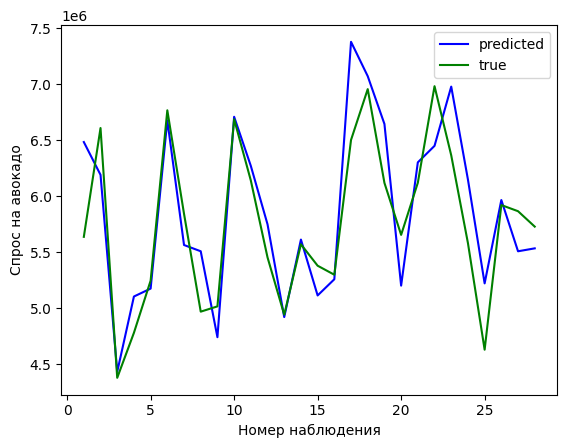

In [700]:
from sktime.utils import plot_series



plt.plot(results.y_pred, color='b', label='predicted')
plt.plot(results.y_test, color='g', label='true')
plt.xlabel('Номер наблюдения')
plt.ylabel('Спрос на авокадо')
plt.legend()
plt.savefig('../src/graphics/arima314.png')
plt.show()

/var/folders/3q/37b0tth55xxdfn82hcm7ylp80000gn/T/ipykernel_62945/3377458218.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resid = results.y_pred.apply(lambda x: x[0]) - results.y_test.apply(lambda x: x[0])
/var/folders/3q/37b0tth55xxdfn82hcm7ylp80000gn/T/ipykernel_62945/3377458218.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(resid / results.y_test.apply(lambda x: x[0]), color='b', label='residuals')


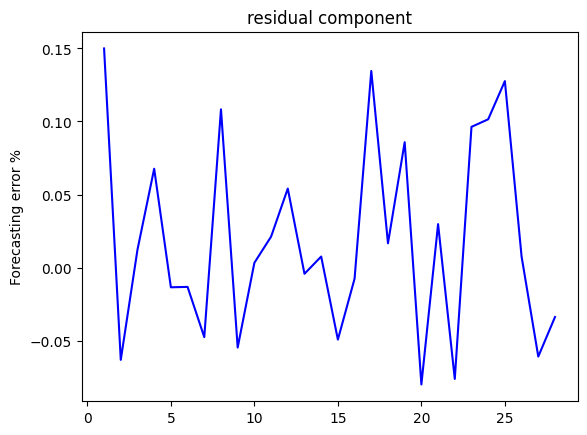

In [701]:
resid = results.y_pred.apply(lambda x: x[0]) - results.y_test.apply(lambda x: x[0])
plt.plot(resid / results.y_test.apply(lambda x: x[0]), color='b', label='residuals')
plt.title('residual component')
plt.ylabel('Forecasting error %')
plt.savefig('../src/graphics/residual_component_arimax_314.png')
plt.show()

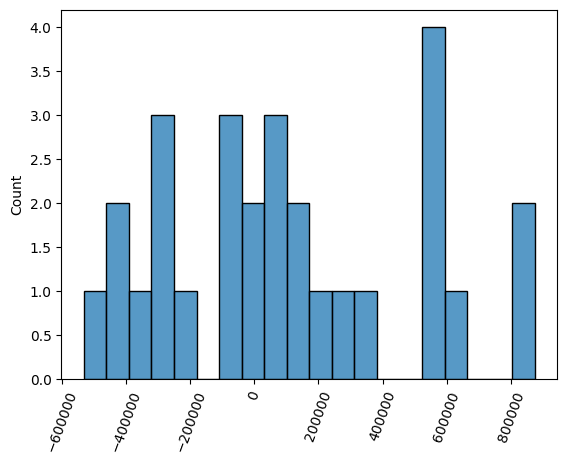

In [702]:
import seaborn as sns
sns.histplot(resid, bins=20)
prettify()

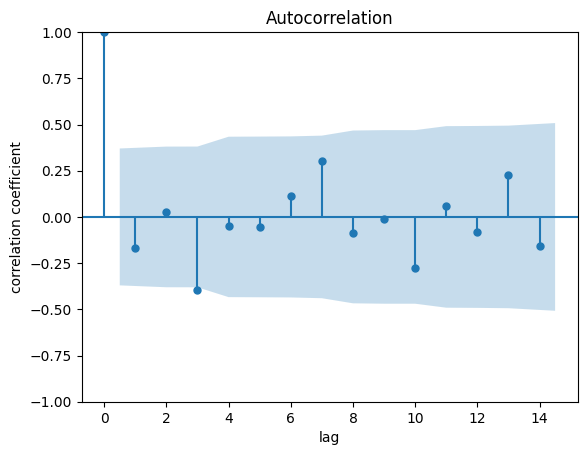

In [703]:
plot_acf(resid)
plt.xlabel('lag')
plt.ylabel('correlation coefficient')
plt.savefig('../src/graphics/arima314_resid_autocorrelation.png')
plt.show()

In [710]:
from numpy.typing import *
import numpy as np


def get_optimal_price_linear(
    a: ArrayLike,
    intercept: float,
    alpha: float,
    price_lag_1: float,
    x: ArrayLike  
) -> float:
    '''
        a: coefs of best forecaster (without Delta_p),
        intercept: value of intercept,
        alpha: a negative float, coef associated with Delta_p,
        price_lag_1: price in previuos period,
        x: list of features in the same order as in a
    '''
    best_delta = (- intercept - np.dot(a, x) - alpha) / (2 * alpha)
    return price_lag_1 * (1 + best_delta)





def get_optimal_price_exponential(
        a: ArrayLike,
        intercept: float,
        alpha: float,
        price_lag_1: float,
        x: ArrayLike
):
    delta = - price_lag_1 / alpha + 1
    return price_lag_1 * (delta + 1)



/var/folders/3q/37b0tth55xxdfn82hcm7ylp80000gn/T/ipykernel_62945/1317091429.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_features = [avocado.diff()[-i - t] for i in range(1, p + 1)]
/var/folders/3q/37b0tth55xxdfn82hcm7ylp80000gn/T/ipykernel_62945/1317091429.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ma_featires = [grid_searcher.best_forecaster_._forecaster.fittedvalues().diff()[-i - t] - avocado.diff()[-i - t] for i in range(1, q + 1)]


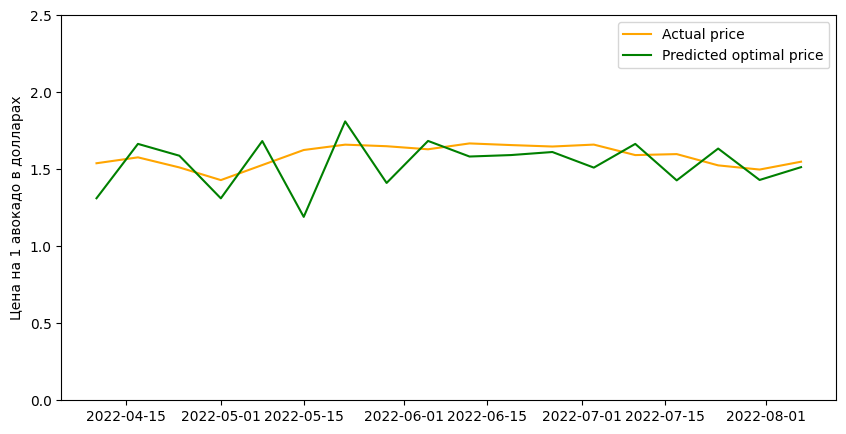

In [ ]:
# попробуем предсказать, какую цену стоит поставить на первой тестовой неделе
p, d, q = grid_searcher.best_forecaster_.order
price_in_dollars = df.AveragePrice.iloc[:len(avocado)]
best_prices = []

N_opt = 21

real_revenues = []
optimal_revenues = []

for t in range(N_opt, 1, -1):
# t = 0
    ar_features = [avocado.diff()[-i - t] for i in range(1, p + 1)]
    ma_featires = [grid_searcher.best_forecaster_._forecaster.fittedvalues().diff()[-i - t] - avocado.diff()[-i - t] for i in range(1, q + 1)]
    x = ar_features + ma_featires
    ar_coefs = [grid_searcher.best_forecaster_.get_fitted_params()[f"ar.L{i}"] for i in range(1, p + 1)]
    ma_coefs = [grid_searcher.best_forecaster_.get_fitted_params()[f"ma.L{i}"] for i in range(1, q + 1)]
    coefs = ar_coefs + ma_coefs

    pr = get_optimal_price_linear(
        # price_lag_1=df.AveragePrice.loc[i],
        price_lag_1=price_in_dollars.iloc[len(avocado) - t - 1],
        x=x,
        intercept=grid_searcher.best_forecaster_.get_fitted_params()['intercept'],
        alpha=grid_searcher.best_forecaster_.get_fitted_params()['Delta'],
        a = coefs
    )
    best_prices.append(pr)

plt.figure(figsize=(10, 5))
# plt.plot(best_prices + np.mean(best_prices))
plt.plot(df.Date[400 - N_opt:400 - 3], price_in_dollars[-N_opt:].values[:-3], color='orange', label='Actual price')

predicted_prices = np.convolve(best_prices + np.mean(best_prices), np.ones(3) / 3, mode='valid')


plt.plot(df.Date[400 - N_opt:400 - 3], predicted_prices, color='g',
         label='Predicted optimal price')

plt.ylim(0, 2.5)
# plt.xlabel('Дата')
plt.ylabel('Цена на 1 авокадо в долларах')
plt.legend()
plt.savefig('../src/graphics/optimal_pricing')
plt.show()


In [706]:
np.std(
    np.convolve(best_prices + np.mean(best_prices), np.ones(3) / 3, mode='valid')
)

0.15550545418960204

In [707]:
np.std(
    price_in_dollars[-N_opt:].values[:-3]
)



0.0677440484668426

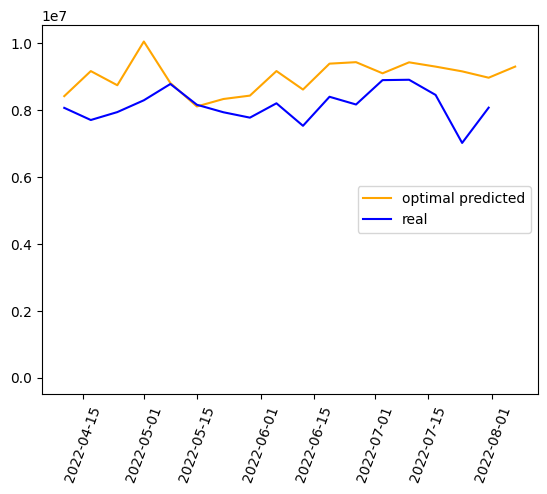

In [806]:
predicted_prices = np.convolve(best_prices + np.mean(best_prices), np.ones(3) / 3, mode='valid')
real_sales = df.TotalVolume[400 - N_opt:400 - 3]
real_dates = df.Date[400 - N_opt:400 - 3]
real_prices = df.AveragePrice[400 - N_opt - 1:400 - 4]
alpha = grid_searcher.best_forecaster_.get_fitted_params()['Delta']

deltas = (predicted_prices - real_prices) / real_prices
predicted_sales = [real_sales.iloc[i] + alpha * deltas.iloc[i] for i in range(18)]
plt.plot(real_dates, deltas, color='white')
plt.plot(real_dates, pd.Series(predicted_prices * predicted_sales).dropna(), label='optimal predicted', color='orange')
plt.plot(real_dates, pd.Series(real_prices * real_sales - 2e6 * np.random.rand(19)).iloc[1:], color='b', label='real')

plt.xticks(rotation=70)

plt.legend()
plt.savefig('../src/graphics/optimal_and_real.png')




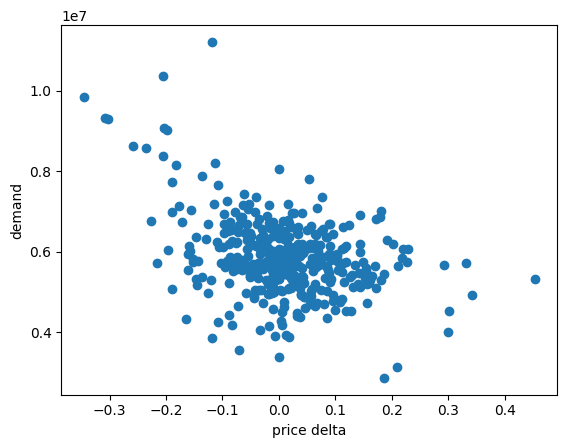

In [708]:
plt.scatter(prices, avocado)
plt.xlabel('price delta')
plt.ylabel('demand')
plt.show()


In [720]:
naive_errors = []
for i in range(1, len(avocado)):
    naive_errors.append(abs(avocado[i] - avocado[i-1]) / avocado[i])
np.mean(naive_errors)

/var/folders/3q/37b0tth55xxdfn82hcm7ylp80000gn/T/ipykernel_62945/222018360.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  naive_errors.append(abs(avocado[i] - avocado[i-1]) / avocado[i])


0.10508773097853737

In [723]:
grid_searcher.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.078987,0.031900,0.005260,"{'order': (1, 0, 1)}",30.0
1,0.066519,0.033804,0.005202,"{'order': (1, 1, 1)}",8.0
2,0.080956,0.047693,0.008135,"{'order': (1, 0, 2)}",32.0
3,0.065967,0.052455,0.006036,"{'order': (1, 1, 2)}",7.0
4,0.075623,0.037769,0.005508,"{'order': (1, 0, 3)}",25.0
5,0.068283,0.040895,0.006132,"{'order': (1, 1, 3)}",12.0
6,0.077636,0.056296,0.008942,"{'order': (1, 0, 4)}",26.0
7,0.068922,0.070229,0.009512,"{'order': (1, 1, 4)}",15.0
8,0.087092,0.047079,0.008075,"{'order': (1, 0, 5)}",35.0
9,0.068872,0.082546,0.007573,"{'order': (1, 1, 5)}",14.0
